In [1]:
import os
import pims as pm
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as spo

import support as sp

%load_ext autoreload
%autoreload 2

In [2]:
mpl.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 150

In [472]:
directory = r"C:\Users\Eric\Documents\Projects\Traps Luminosity Pictures\20191002"
name = "radius_678Hz_2_2019_10_02_17_06_33"

#"radius_564Hz_2_2019_10_02_17_07_21"  #"radius_529Hz_2_2019_10_02_17_05_59"
#"radius_498Hz_2_2019_10_02_17_04_58"#"radius_471Hz_2_2019_10_02_17_07_57" #
#"radius_433Hz_2_2019_10_02_17_08_28" #


In [473]:
video = pm.open(os.path.join(directory,name+r"\*.bmp"))

In [474]:
n_frames = len(video)
integral = video[0]/n_frames

for v in video[1:]:
    integral = integral+v/n_frames

Frame([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.26829268],
       [0.        , 0.        , 3.41463415, ..., 3.01219512, 2.76829268,
        0.91463415],
       ...,
       [0.        , 0.        , 2.7804878 , ..., 2.03658537, 2.26829268,
        4.13414634],
       [1.98780488, 1.68292683, 5.59756098, ..., 4.90243902, 5.41463415,
        3.3902439 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.30487805]])
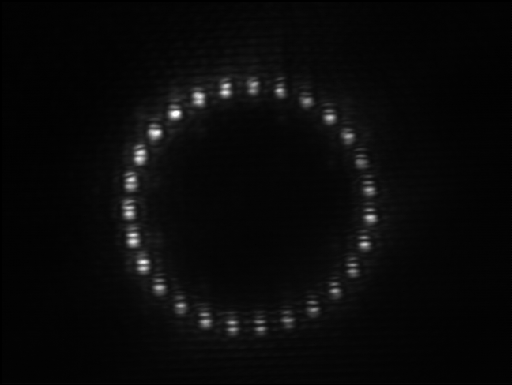

In [475]:
integral

In [476]:
x = np.arange(np.shape(integral)[1])
y = np.arange(np.shape(integral)[0])
X,Y = np.meshgrid(x,y)

w = 10

def ring(i,cx, cy, radius):
    cx, cy, radius
    R = np.sqrt((X.flatten()[i]-cx)**2+(Y.flatten()[i]-cy)**2)
    return np.exp(-(R-radius)**2/(2*w**2))


In [477]:
center_0 = [np.shape(integral)[1]/2,np.shape(integral)[0]/2]
radius_0 = 100

In [478]:
fit = spo.curve_fit(ring, 
                    np.arange(np.size(integral)),integral.flatten(), 
                    p0 = [*center_0,radius_0])

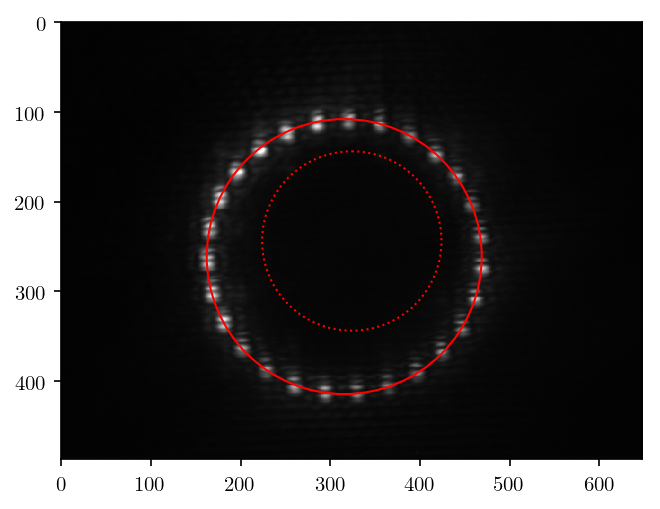

In [479]:
plt.figure(figsize=(5,5))
plt.imshow(integral, cmap = "gray")
c0 = mpl.patches.Circle(center_0, radius = radius_0, color = "red",fill=False, linewidth = 1, linestyle = ":")
c = mpl.patches.Circle(fit[0][0:2],radius = fit[0][2], color = "red",fill=False, linewidth = 1)
plt.gca().add_patch(c0)
plt.gca().add_patch(c)

In [480]:
radius = fit[0][2]
center = fit[0][0:2]

In [481]:
phi = np.linspace(0,2*np.pi,1000)

In [482]:
p = np.array([radius*np.cos(phi)+center[0],radius*np.sin(phi)+center[1]]).transpose()

In [483]:
p_i = np.round(p).astype("int")
profile = np.array(integral[p_i[:,1],p_i[:,0]])

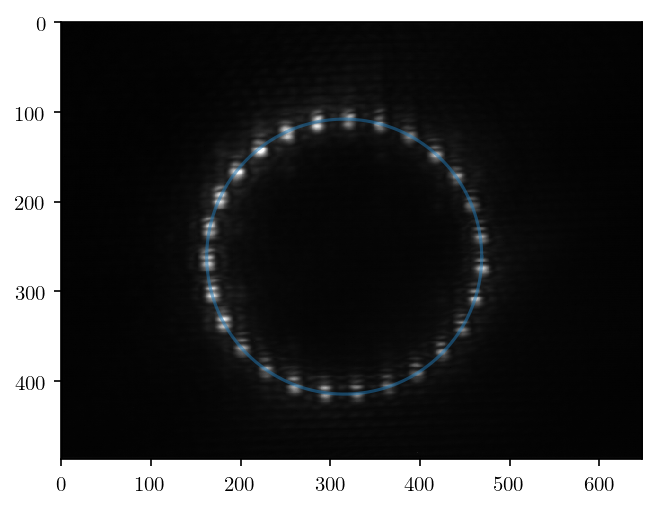

In [484]:
plt.figure(figsize=(5,5))
plt.imshow(integral, cmap = "gray")
plt.plot(p[:,0],p[:,1], alpha = 0.5)

(0, 255)

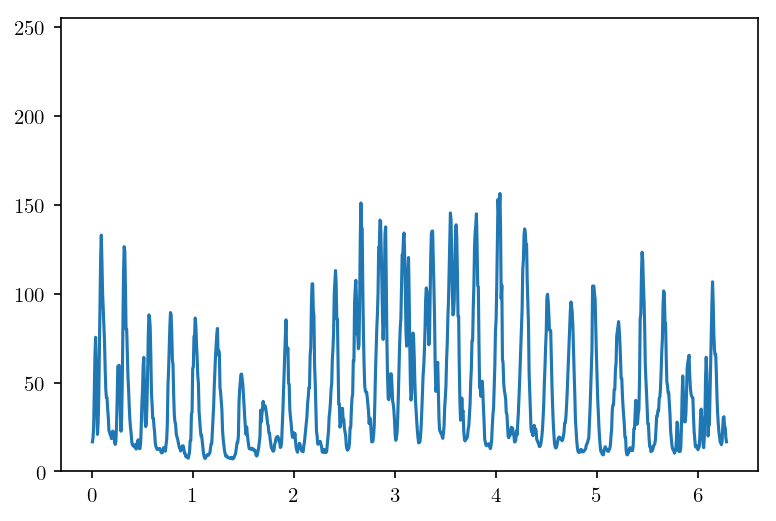

In [485]:
plt.plot(phi,profile) #255-profile
plt.ylim(0,255)


Envelope Wave Fit Parameters: 
Amplitude =  19.814198614130238 ; Wave number =  1.5177056451254003 ; Phase =  2.7233126027469443 ; Mean =  47.65288653349165


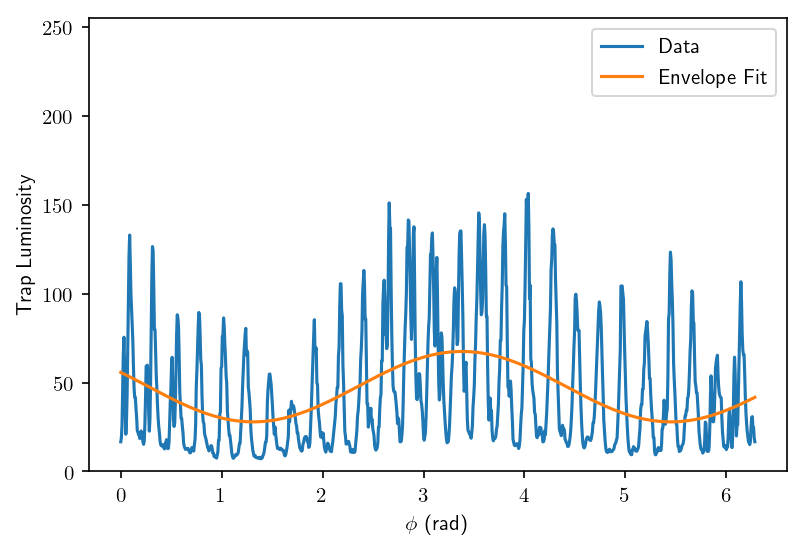

In [486]:
#estimation of the sinusoidal function prameters 
guess_mean = np.mean(profile)
guess_std = 3*np.std(profile)/(2**0.5)
guess_phase = 0
guess_freq = 2 
guess_trap_freq = 27 #for trap position sinusoidal fitting
guess_amp = 25

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = guess_std*np.sin(guess_freq*phi+guess_phase) 

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda y: y[0]*np.sin(y[1]*phi+y[2]) + y[3] - profile
est_amp, est_freq, est_phase, est_mean = spo.leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
envelope_fit = est_amp*np.sin(est_freq*phi+est_phase) + est_mean


t_est_amp, t_est_freq, t_est_phase, t_est_mean = spo.leastsq(optimize_func, [guess_amp, guess_trap_freq, guess_phase, guess_mean])[0]
trap_pos_fit = t_est_amp*np.sin(t_est_freq*phi+t_est_phase) + t_est_mean

print('\nEnvelope Wave Fit Parameters: \nAmplitude = ', est_amp, '; Wave number = ', est_freq, '; Phase = ', est_phase,
      '; Mean = ', est_mean)
# print('\nTrap Position Fit Parameters: \nAmplitude = ', t_est_amp, '; Frequency = ', t_est_freq, '; Phase = ', t_est_phase,
#       '; Mean = ', t_est_mean)

plt.plot(phi, profile, label='Data')
plt.plot(phi, envelope_fit, label='Envelope Fit')
#plt.plot(phi, trap_pos_fit,'y-', label="Trap Position Fit")

plt.ylabel("Trap Luminosity")
plt.xlabel(r"$\phi$ (rad)")
plt.ylim(0,255)
plt.legend();

In [487]:
#max_fit_values = trap_pos_fit[np.r_[True, trap_pos_fit[1:] < trap_pos_fit[:-1]] & np.r_[trap_pos_fit[:-1] < trap_pos_fit[1:], True]]
max_fit_values = profile[np.r_[True, trap_pos_fit[1:] > trap_pos_fit[:-1]] & np.r_[trap_pos_fit[:-1] > trap_pos_fit[1:], True]]
# print(len(max_fit_values))
# max_fit_values

In [488]:
phi_traps = phi[np.r_[True, trap_pos_fit[1:] > trap_pos_fit[:-1]] & np.r_[trap_pos_fit[:-1] > trap_pos_fit[1:], True]]
# print(len(phi_traps))
# phi_traps

In [489]:
phi_traps = phi_traps[max_fit_values>80]
max_fit_values = max_fit_values[max_fit_values>80]

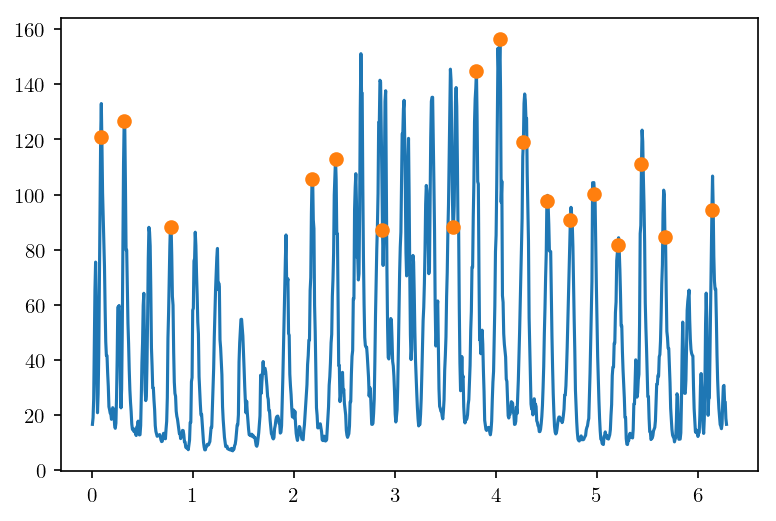

In [490]:
plt.plot(phi, profile)
plt.plot(phi_traps, max_fit_values, 'o')

In [491]:
phi_traps

array([0.08176317, 0.31447374, 0.77989487, 2.17615827, 2.40886884,
       2.87428998, 3.57242168, 3.80513224, 4.03784281, 4.27055338,
       4.50326394, 4.73597451, 4.97497455, 5.20768512, 5.44039569,
       5.67310625, 6.13852739])

In [464]:
delta_1 = max_fit_values[-9] - (est_amp*np.sin(est_freq*phi_traps[-9]+est_phase) + est_mean)
#max_envelope_1 = envelope_fit+delta_1
delta_1

81.58260700348607

In [495]:
delta_2 = max_fit_values[-3] - (est_amp*np.sin(est_freq*phi_traps[-3]+est_phase) + est_mean)
#max_envelope_2 = envelope_fit+delta_2
delta_2

83.15898008971229

In [496]:
delta = (delta_1+delta_2)/2
print(delta)
max_envelope = envelope_fit+delta

82.37079354659917


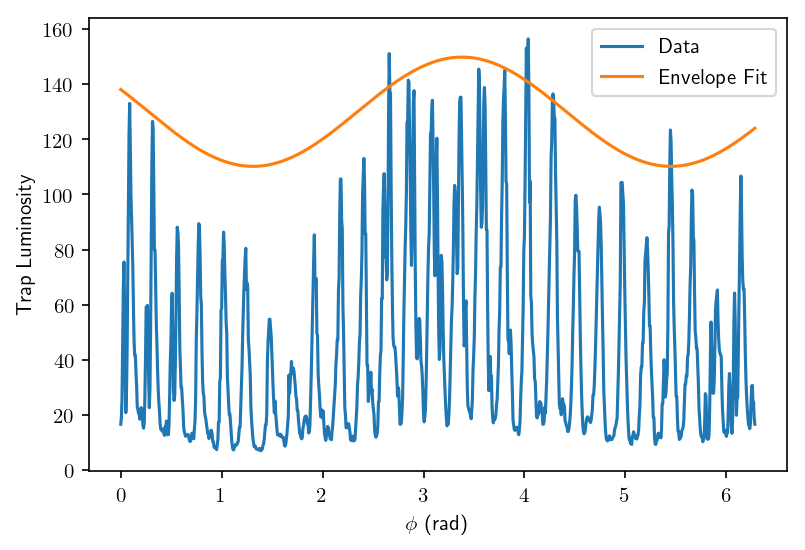

In [497]:
plt.plot(phi, profile, label='Data')
plt.plot(phi, max_envelope, label='Envelope Fit')
# plt.plot(phi, envelope_fit+delta_1, label='Envelope Fit')
# plt.plot(phi, envelope_fit+delta_2, label='Envelope Fit')

plt.ylabel("Trap Luminosity")
plt.xlabel(r"$\phi$ (rad)")
plt.legend();

In [498]:
Imax = max_envelope[np.r_[True, max_envelope[1:] > max_envelope[:-1]] & np.r_[max_envelope[:-1] > max_envelope[1:], True]][1]
print("Envelope maximum = ", Imax)
Imin = max_envelope[np.r_[True, max_envelope[1:] < max_envelope[:-1]] & np.r_[max_envelope[:-1] < max_envelope[1:], True]][0]
print("Envelope minimum = ", Imin)

Envelope maximum =  149.83766010753368
Envelope minimum =  110.20960968572291


In [499]:
Imin/Imax

0.7355267668130229

In [500]:
offset = est_mean+ delta
offset

130.02368008009083

In [501]:
phi_mins = phi[np.r_[True, max_envelope[1:] < max_envelope[:-1]] & np.r_[max_envelope[:-1] < max_envelope[1:], True]]
wavelength = phi_mins[1] - phi_mins[0]
wavelength

4.1447638813126595

In [202]:
print("Mean value = ",np.mean(max_fit_values))
print("Standard deviation = ", np.std(max_fit_values))
print("Minimum value = ", min(max_fit_values))
print("Maximum value = ", max(max_fit_values))
print("Min/Max ratio = ", min(max_fit_values)/max(max_fit_values))

Mean value =  90.27777777777776
Standard deviation =  27.99080637880742
Minimum value =  36.97560975609754
Maximum value =  156.43902439024401
Min/Max ratio =  0.23635796694730246


### Until here

In [27]:
phi_val_max = phi[np.r_[True, profile[1:] > profile[:-1]] & np.r_[profile[:-1] > profile[1:], True]]
len(phi_val_max)

63

In [25]:
max_values = profile[np.r_[True, profile[1:] > profile[:-1]] & np.r_[profile[:-1] > profile[1:], True]]
#max_values = max_values[max_values>56]
print(len(max_values))
max_values

63


array([ 90.73417722,  66.72151899,  31.94936709,  58.79746835,
        54.97468354,  94.10126582,  89.53164557, 125.60759494,
       130.08860759,  86.50632911,  82.17721519,  58.12658228,
        58.16455696,  58.48101266,  64.58227848,  21.32911392,
        18.74683544,  48.7721519 , 121.6835443 , 106.13924051,
        33.91139241,  32.56962025,  56.30379747,  73.87341772,
       103.13924051, 114.40506329,  50.48101266, 142.89873418,
       147.65822785, 163.35443038, 134.81012658, 162.46835443,
       164.83544304,  98.06329114, 114.70886076,  90.78481013,
        64.67088608,  58.21518987,  75.60759494, 144.24050633,
       142.44303797,  26.59493671,  78.15189873,  56.87341772,
        32.37974684,  70.67088608,  54.74683544,  26.25316456,
        93.05063291,  64.        ,  61.18987342,  91.72151899,
       115.62025316, 123.20253165, 117.60759494,  44.40506329,
        46.51898734,  61.93670886,  47.06329114,  89.84810127,
        65.05063291,  92.4556962 ,  61.15189873])

In [237]:
phi_val_max = phi_val_max[max_values>140]
max_values = max_values[max_values>140]

In [242]:
phi_val_max[-3]

3.1447373909807737

In [134]:
print("Mean value = ",np.mean(max_values))
print("Standard deviation = ", np.std(max_values))
print("Minimum value = ", min(max_values))
print("Maximum value = ", max(max_values))
print("Min/Max ratio = ", min(max_values)/max(max_values))

Mean value =  81.85955394816153
Standard deviation =  37.89048529967425
Minimum value =  18.746835443037966
Maximum value =  164.8354430379747
Min/Max ratio =  0.11373060973736747


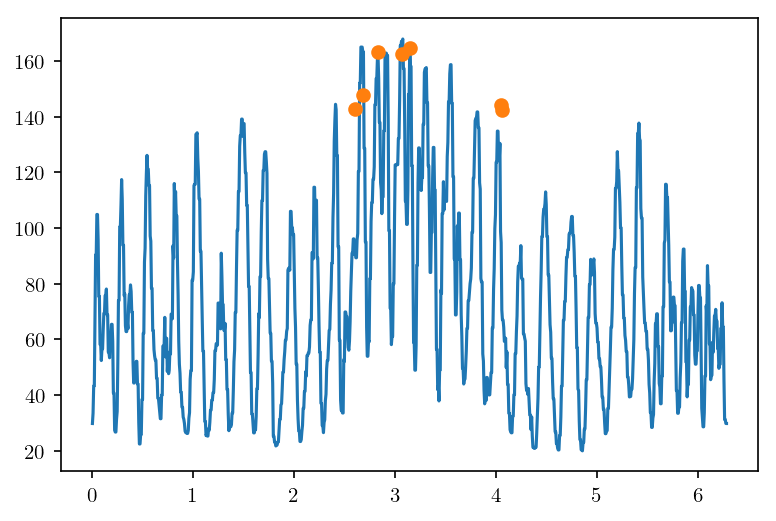

In [238]:
plt.plot(phi, profile)
plt.plot(phi_val_max, max_values, 'o')
#plt.plot(phi_traps, max_fit_values, 'o')